In [ ]:
import cv2
import os
import numpy as np
from sklearn.cluster import KMeans
from scipy.sparse.linalg import eigsh
import matplotlib.pyplot as plt

In [ ]:
def resize_images(images):
    resized_images = []
    for img in images:
        resized_img = cv2.resize(img,(64,64))
        resized_images.append(resized_img)
    return resized_images

def read_images(path):
    images = []
    for filename in os.listdir(path):
        img = cv2.imread(os.path.join(folder_path, filename),cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
    return images

def kmeans(image,k):
    kmeans = KMeans(n_clusters=k,n_init=10,random_state=42)
    kmeans.fit(image)
    cluster_assignments = kmeans.labels_
    return cluster_assignments.tolist()


def visualize_segmentation(image, cluster_labels_3, cluster_labels_6, mode):
    fig, axs = plt.subplots(1, 3, figsize=(15, 10))

    axs[0].imshow(image.reshape((64,64)))
    axs[0].axis('off')
    axs[0].set_title(f'Original Image (Grayscaled)')

    segmented_image_3 = np.reshape(cluster_labels_3, (64, 64))
    axs[1].imshow(segmented_image_3, cmap='magma')
    axs[1].axis('off')
    axs[1].set_title(f'Segmentation Result for {mode} (k=3)')

    segmented_image_6 = np.reshape(cluster_labels_6, (64, 64))
    axs[2].imshow(segmented_image_6, cmap='magma')
    axs[2].axis('off')
    axs[2].set_title(f'Segmentation Result for {mode} (k=6)')

    plt.tight_layout()
    plt.show()


# def construct_similarity_graph_euclidean(image):
#     image_vector = image.flatten()
#     num_pixels = len(image_vector)

#     similarity_matrix = np.zeros((num_pixels, num_pixels))
#     for i in range(num_pixels):
#         for j in range(num_pixels):
#             similarity_matrix[i, j] = abs(image_vector[i] - image_vector[j])

#     threshold = np.median(similarity_matrix)

#     similarity_matrix[similarity_matrix > threshold] = 0

#     adjacency_matrix = np.exp(-similarity_matrix ** 2 / (2 * threshold ** 2))
#     np.fill_diagonal(adjacency_matrix, 0)

#     return adjacency_matrix

def construct_similarity_graph(image, sigma=5):
    height, width = image.shape
    num_pixels = height * width

    image_vector = image.flatten()

    similarity_matrix = np.zeros((num_pixels, num_pixels))
    for i in range(num_pixels):
        for j in range(num_pixels):
            diff = abs(image_vector[i] - image_vector[j])
            similarity_matrix[i, j] = np.exp(-diff**2 / (2 * sigma**2))

    np.fill_diagonal(similarity_matrix, 0)

    return similarity_matrix

def calculate_laplacian(adjacency_matrix):
    degree_matrix = np.diag(np.sum(adjacency_matrix, axis=1))
    laplacian_matrix = degree_matrix - adjacency_matrix
    return laplacian_matrix

def calculate_eigenvectors(laplacian_matrix, k):
    eigenvalues, eigenvectors = np.linalg.eigh(laplacian_matrix)
    selected_eigenvalues = eigenvalues[:k]
    selected_eigenvectors = eigenvectors[:, :k]
    return selected_eigenvectors

def spectral_clustering(image,k):

    adjacency_matrix = construct_similarity_graph(image)

    laplacian_matrix = calculate_laplacian(adjacency_matrix)

    selected_eigenvectors = calculate_eigenvectors(laplacian_matrix, k)

    clusters = kmeans(selected_eigenvectors,k)

    return clusters

In [ ]:
def mutual_information(hist1, hist2):
    joint_histogram = np.histogram2d(hist1, hist2, bins=(np.arange(np.max(hist1) + 2), np.arange(np.max(hist2) + 2)))[0]
    joint_prob = joint_histogram / np.sum(joint_histogram)
    marginal_prob_1 = np.sum(joint_prob, axis=1)
    marginal_prob_2 = np.sum(joint_prob, axis=0)
    mutual_info = 0
    for i in range(len(marginal_prob_1)):
        for j in range(len(marginal_prob_2)):
            if joint_prob[i, j] > 0:
                mutual_info += joint_prob[i, j] * np.log(joint_prob[i, j] / (marginal_prob_1[i] * marginal_prob_2[j]))
    return mutual_info

def entropy(hist):
    prob = hist / np.sum(hist)
    entropy = -np.sum(prob * np.log(prob + 1e-9))
    return entropy

def evaluate_segmentation(segmentation1, segmentation2):
    hist_1, _ = np.histogram(segmentation1, bins=np.arange(np.max(segmentation1) + 2))
    hist_2, _ = np.histogram(segmentation2, bins=np.arange(np.max(segmentation2) + 2))
    mutual_info = mutual_information(hist_1, hist_2)
    entropy_1 = entropy(hist_1)
    entropy_2 = entropy(hist_2)
    nmi = mutual_info / np.sqrt(entropy_1 * entropy_2)
    return nmi


Evaluation for image 0
3 clusters - Ratio-Cut and K-means Normalized Mutual Information : 1.9213649452844264
6 clusters - Ratio-Cut and K-means Normalized Mutual Information : 1.6718013134775034



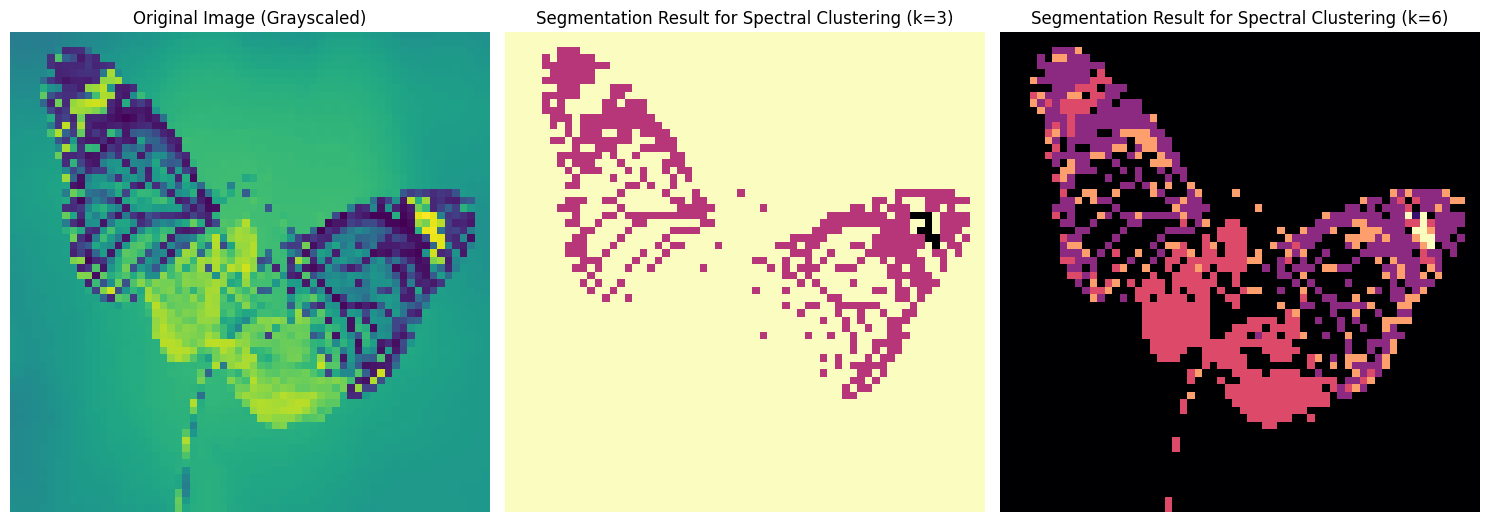

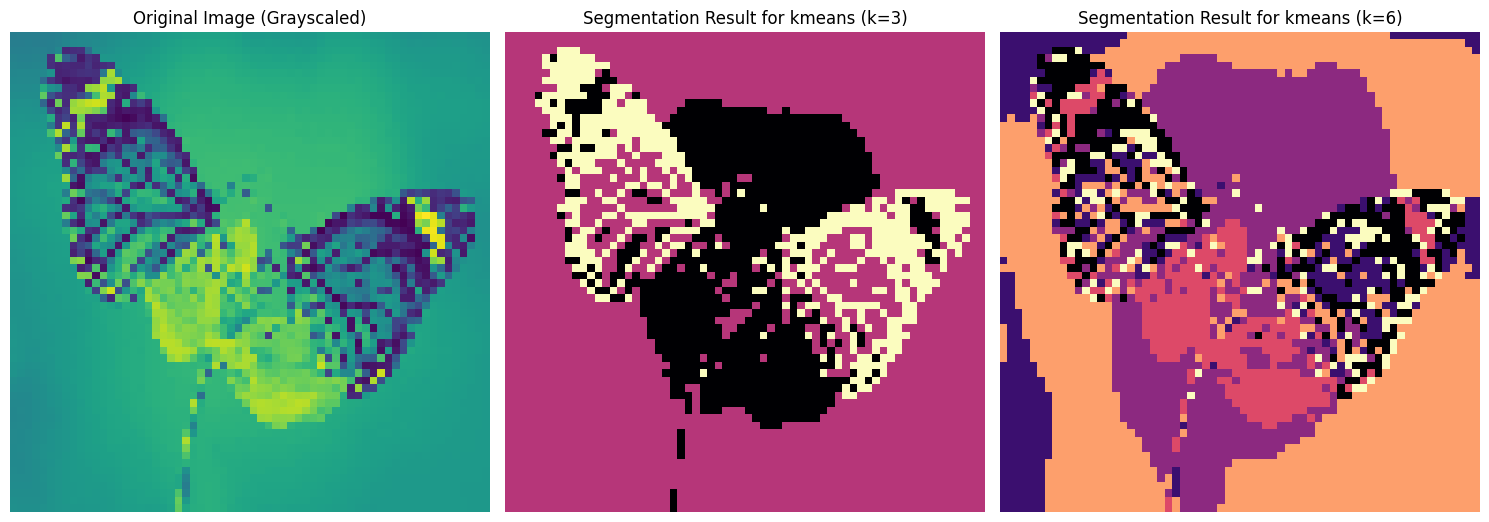


Evaluation for image 1
3 clusters - Ratio-Cut and K-means Normalized Mutual Information : 1.6473266705566707
6 clusters - Ratio-Cut and K-means Normalized Mutual Information : 1.9879274711796635



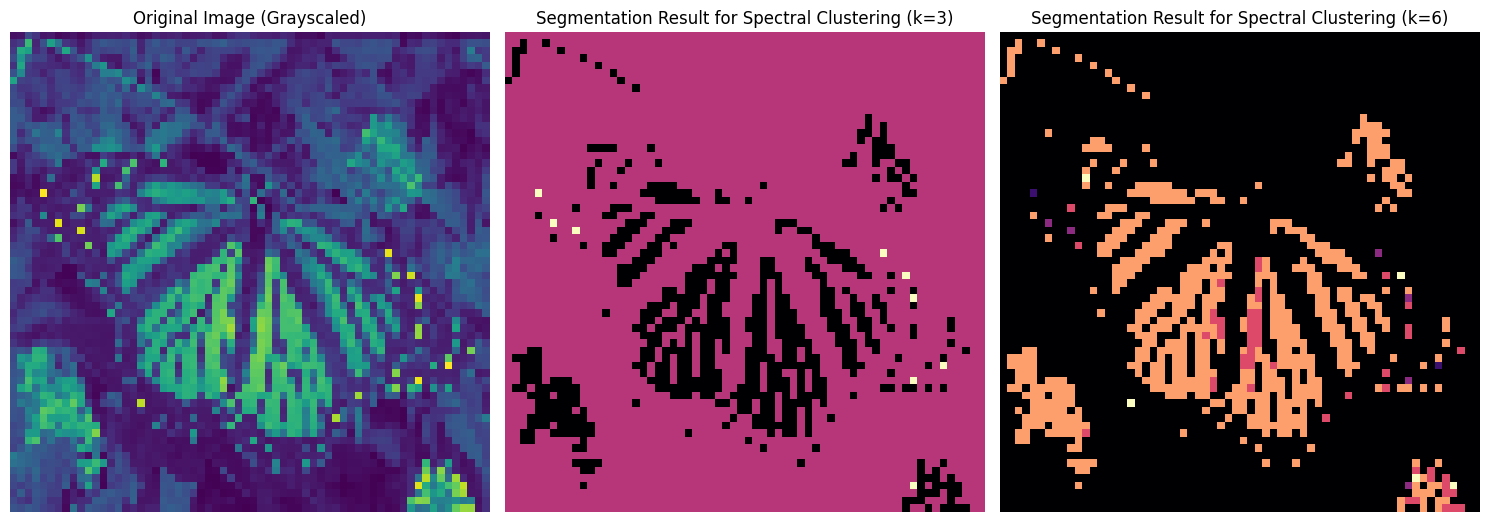

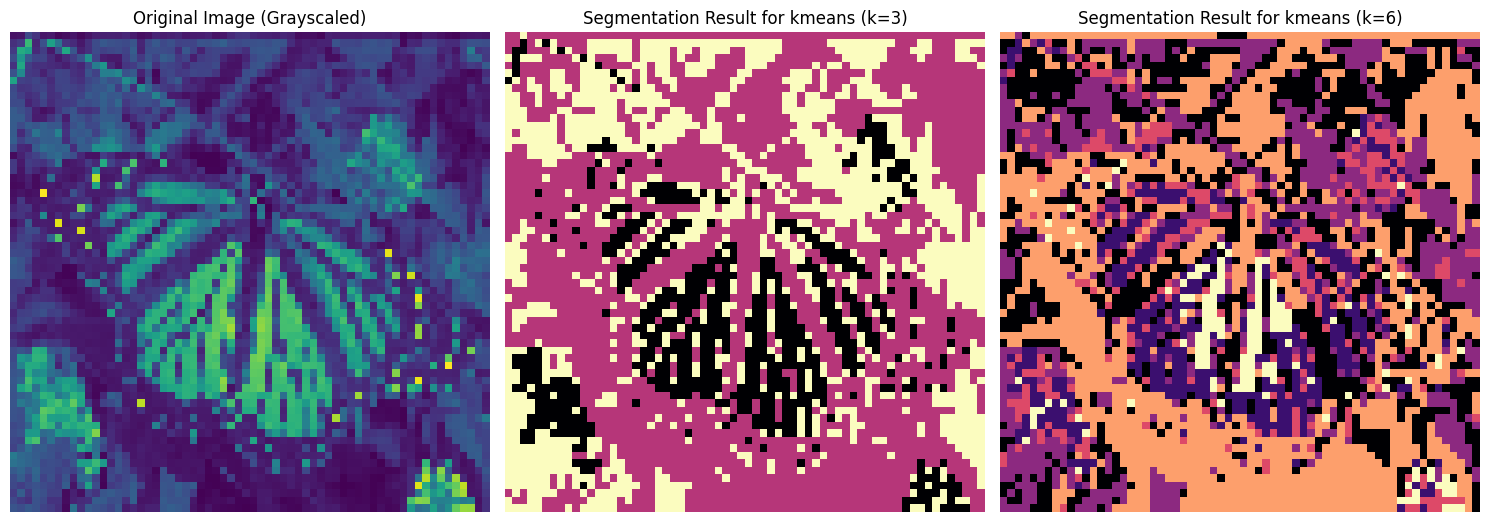

In [ ]:
folder_path = '/kaggle/input/cv-ass3/cvasg2'
images = read_images(folder_path)
resized_images = resize_images(images)


for i, image in enumerate(resized_images):
    image = np.array(image).reshape(-1, 1).astype(np.float64)

    kmeans_3_clusters = kmeans(image,3)
    kmeans_6_clusters = kmeans(image,6)

    ratio_cut_3_clusters = spectral_clustering(image , 3)
    ratio_cut_6_clusters = spectral_clustering(image , 6)

    evaluation_3_ratio_cut_vs_kmeans = evaluate_segmentation(ratio_cut_3_clusters, kmeans_3_clusters)
    evaluation_6_ratio_cut_vs_kmeans = evaluate_segmentation(ratio_cut_6_clusters, kmeans_6_clusters)

    print("")

    print(f"Evaluation for image {i}")
    print("3 clusters - Ratio-Cut and K-means Normalized Mutual Information :", evaluation_3_ratio_cut_vs_kmeans)
    print("6 clusters - Ratio-Cut and K-means Normalized Mutual Information :", evaluation_6_ratio_cut_vs_kmeans)

    print("")

    visualize_segmentation(image,ratio_cut_3_clusters ,ratio_cut_6_clusters, mode = 'Spectral Clustering')
    visualize_segmentation(image,kmeans_3_clusters ,kmeans_6_clusters, mode = 'kmeans')